# StroopActFlow
### Localize hidden units for Stroop Model
### Use neutral trials only for S-R associations for different task contexts
### Color task hidden units: Green color input -> Green response; Red color input ->  Red response
### Word task hidden units: GREEN word input -> Green response; RED word input -> Red response

#### Taku Ito
#### 02/24/17


In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import statsmodels.sandbox.stats.multicomp as mc
import os
import nibabel as nib
from sklearn.svm import SVC
import utils
glasserfile = '/projects3/StroopActFlow/data/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_LR.dlabel.nii'

In [19]:
def convertCSVToCIFTI64k(inputfilename,outputfilename):
    basedir = '/projects/AnalysisTools/ParcelsGlasser2016/'
    ciftitemplate = glasserfile
    wb_command = 'wb_command -cifti-convert -from-text' 
    wb_command += ' ' + inputfilename 
    wb_command += ' ' + ciftitemplate
    wb_command += ' ' + outputfilename
    wb_command += " -col-delim ','"
    wb_command += ' -reset-scalars'
    os.system(wb_command)
#     print wb_command

## 0.0 Set up

In [20]:
subjNums = ['101', '102']

basedir = '/projects3/StroopActFlow/data/'
resultsdir = basedir + 'results/'
restdir = resultsdir + 'glmRest_GlasserParcels/'

glasser_nets = np.loadtxt(basedir + 'NetworkPartitions3.1/indexsort.txt', delimiter=',')
# Make into python numbering (starts from 0)
glasser_nets -= 1.0
networkorder = glasser_nets.astype(int)
networkorder.shape = (len(networkorder),1)

networkmappings = {'fpn':6, 'vis':1, 'smn':2, 'con':3, 'dmn':8, 'aud':7, 'van':5, 'dan':4}
networks = networkmappings.keys()

networkdef = basedir + 'NetworkPartitions3.1/network_partition.txt'
networkdef = np.loadtxt(networkdef, delimiter=',')
networkdef2 = np.zeros((networkdef.shape))
networkdef2[0:180] = networkdef[180:]
networkdef2[180:] = networkdef[0:180]
networkdef = networkdef2

# glasserparcels = lg.loadGlasserParcels()
# networkdef2 = lg.loadGlasserNetworks()

xticks = {}
reorderednetworkaffil = networkdef[networkorder]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net
    
# Load in Glasser parcels
# glasserfile = '/projects3/StroopActFlow/data/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_LR.dlabel.nii'
glasser = nib.load(glasserfile).get_data()
glasser = np.squeeze(glasser)

## 2.0 Run task activation analysis on 64k Surface for 2 rule encodings

In [21]:
def loadBetas(subj):
    datadir = '/projects3/StroopActFlow/data/results/glm_hiddenLayerLocalizer/'
    betas = np.loadtxt(datadir + subj + '_hiddenLayer_taskBetas_Surface64k.csv',delimiter=',')
    
#     nruleBetas = 60
    
    betas = betas[:,-4:] # Last 2 are the task rule betas
    return betas

## 2.1 Run GLM contrast between color V. word S-R associations
* Hidden units 1: Color rule hidden units
* Hidden units 2: Word rule hidden units

##### Load in data as dicts

In [59]:
nrules = 2

beta_dict = {}
behavdata = {}

# Organize subject betas by stimulus
zcontrast = np.zeros((glasser.shape[0],3)) # 1st subj; 2nd subj; average
i = 0
for subj in subjNums:
    beta_dict[subj] = np.zeros((glasser.shape[0],2))
    print 'Loading betas for subject', subj
#     smoothMap(subj)
    # Average together the COLOR representations
    beta_dict[subj][:,0] = np.mean(loadBetas(subj)[:,0:2],axis=1) ### 0-1 are the COLOR indices
    # Average together the WORD representations
    beta_dict[subj][:,1] = np.mean(loadBetas(subj)[:,2:],axis=1) ### 2-3 are the WORD indices
    
#     pval_mask = loadPvals(subj)[:,0:2] < 0.05
    # Only include SMN vertices
    rois = []
    rois.extend(np.where(networkdef==networkmappings['van'])[0])
    rois.extend(np.where(networkdef==networkmappings['dan'])[0])
    
    roi_ind = []
    for roi in rois:
        roi_ind.extend(np.where(glasser==roi+1)[0])
    roi_ind = np.reshape(np.asarray(roi_ind),-1)
#     left_ind = stats.zscore(beta_dict[subj][roi_ind,0],axis=0)
#     right_ind = stats.zscore(beta_dict[subj][roi_ind,1],axis=0)
    color_ind = beta_dict[subj][roi_ind,0]
    word_ind = beta_dict[subj][roi_ind,1]
    zcontrast[roi_ind,i] = stats.zscore(color_ind - word_ind, axis=0)
    zcontrast[roi_ind,2] = zcontrast[roi_ind,2] + (color_ind - word_ind)
    i += 1
# Average
zcontrast[roi_ind,2] = stats.zscore(zcontrast[roi_ind,2]/2.0,axis=0)

# Apply threshold
zthresh = 0 # p < 0.05 for z-values
for i in range(zcontrast.shape[1]):
    tmp = np.abs(zcontrast[:,i]) > zthresh
    zcontrast[:,i] = np.multiply(zcontrast[:,i],tmp)
    
# Identify vertices sensitive to color, and vertices sensitive to word (for future contrast)
color_ind = {}
word_ind = {}
for i in range(zcontrast.shape[1]):
    color_ind[i] = np.where(zcontrast[:,i] > 0)[0]
    word_ind[i] = np.where(zcontrast[:,i] < 0)[0]

Loading betas for subject 101
Loading betas for subject 102


## 2.1.2 Save t-statistic contrast maps for each subject and average to CSV and dscalar file

In [23]:
basedir = '/projects3/StroopActFlow/data/results/glm_hiddenLayerLocalizer//'
filerule = basedir+'zcontrast_ColorVWord_HiddenLayerLocalization'
np.savetxt(filerule+'.csv', zcontrast, delimiter=',')

convertCSVToCIFTI64k(filerule+'.csv', filerule+'.dscalar.nii')


## 2.2 Hidden layer color representation localization: Load in t-maps (obtained from regressors against 0) for each COLOR stimulus, and contrast the t-maps

##### This is not a rigorous statistical test. Perform this for each subject, and then compute an 'average' contrast t-map

In [60]:
nrules = 2

beta_dict = {}
behavdata = {}

# Organize subject betas by stimulus
zcontrast_color = np.zeros((glasser.shape[0],3)) # 1st subj; 2nd subj; average
i = 0
for subj in subjNums:
    beta_dict[subj] = np.zeros((glasser.shape[0],2))
    print 'Loading betas for subject', subj
#     smoothMap(subj)
    beta_dict[subj][:,:] = loadBetas(subj)[:,0:2] ### 0-2 are the COLOR indices
#     pval_mask = loadPvals(subj)[:,0:2] < 0.05
#     # Only include VIS vertices
#     rois = np.where(networkdef==networkmappings['vis'])[0]
#     roi_ind = []
#     for roi in rois:
#         roi_ind.extend(np.where(glasser==roi)[0])
#     roi_ind = np.reshape(np.asarray(roi_ind),-1)
#     left_ind = stats.zscore(beta_dict[subj][roi_ind,0],axis=0)
#     right_ind = stats.zscore(beta_dict[subj][roi_ind,1],axis=0)
    green_ind = beta_dict[subj][color_ind[i],0]
    red_ind = beta_dict[subj][color_ind[i],1]
    zcontrast_color[color_ind[i],i] = stats.zscore(green_ind - red_ind, axis=0)
    zcontrast_color[color_ind[2],2] = zcontrast_color[color_ind[2],2] + (beta_dict[subj][color_ind[2],0] - beta_dict[subj][color_ind[2],1])
    i += 1
# Average
zcontrast_color[color_ind[2],2] = stats.zscore(zcontrast_color[color_ind[2],2]/2.0,axis=0)


        

Loading betas for subject 101
Loading betas for subject 102


## 2.3 Save t-statistic contrast maps for each subject and average to CSV and dscalar files

In [26]:
basedir = '/projects3/StroopActFlow/data/results/glm_hiddenLayerLocalizer/'
filerule = basedir+'zcontrast_hiddenLayerColor_GreenVRed'

np.savetxt(filerule+'.csv', zcontrast_color, delimiter=',')

convertCSVToCIFTI64k(filerule+'.csv', filerule+'.dscalar.nii')


## 2.4 Word representation localization: Load in t-maps (obtained from regressors against 0) for each WORD stimulus, and contrast the t-maps

##### This is not a rigorous statistical test. Perform this for each subject, and then compute an 'average' contrast t-map

In [61]:
nrules = 2

beta_dict = {}
behavdata = {}

# Organize subject betas by stimulus
zcontrast_word = np.zeros((glasser.shape[0],3)) # 1st subj; 2nd subj; average
i = 0
for subj in subjNums:
    beta_dict[subj] = np.zeros((glasser.shape[0],2))
    print 'Loading betas for subject', subj
#     smoothMap(subj)
    beta_dict[subj][:,:] = loadBetas(subj)[:,2:] ### 2: are the WORD indices
#     # Only include VIS vertices
#     rois = np.where(networkdef==networkmappings['vis'])[0]
#     roi_ind = []
#     for roi in rois:
#         roi_ind.extend(np.where(glasser==roi)[0])
#     roi_ind = np.reshape(np.asarray(roi_ind),-1)
#     left_ind = stats.zscore(beta_dict[subj][roi_ind,0],axis=0)
#     right_ind = stats.zscore(beta_dict[subj][roi_ind,1],axis=0)
    green_ind = beta_dict[subj][word_ind[i],0]
    red_ind = beta_dict[subj][word_ind[i],1]
    zcontrast_word[word_ind[i],i] = stats.zscore(green_ind - red_ind, axis=0)
    zcontrast_word[word_ind[2],2] = zcontrast_word[word_ind[2],2] + (beta_dict[subj][word_ind[2],0] - beta_dict[subj][word_ind[2],1])
    i += 1
# Average
zcontrast_word[word_ind[2],2] = stats.zscore(zcontrast_word[word_ind[2],2]/2.0,axis=0)

        

Loading betas for subject 101
Loading betas for subject 102


## 2.5 Save t-statistic contrast maps for each subject and average to CSV and dscalar files

In [28]:
basedir = '/projects3/StroopActFlow/data/results/glm_hiddenLayerLocalizer/'
filerule = basedir+'zcontrast_hiddenLayerWord_GreenVRed'

np.savetxt(filerule+'.csv', zcontrast_word, delimiter=',')

convertCSVToCIFTI64k(filerule+'.csv', filerule+'.dscalar.nii')


# 3.0 Estimate biases for each hidden unit

#### Now loadStimBetas

In [31]:
def loadStimBetas(subj):
    datadir = '/projects3/StroopActFlow/data/results/glm_ruleStimBetaSeries/'
    betas = np.loadtxt(datadir + subj + '_RuleAndStimBetaSeries_taskBetas_Surface64k.csv',delimiter=',')
    
    nruleBetas = 60
    
    betas = betas[:,18+nruleBetas:] # 18 onwards are the two task betas
    return betas

## 3.1 First estimate biases for color hidden units

In [228]:
nrules = 2

beta_dict = {}
behavdata = {}
allbetas = {}
# Organize subject betas by stimulus
for subj in subjNums:
    print 'Loading betas for subject', subj
    betas = loadStimBetas(subj)
    behavdata[subj] = utils.loadBehavData(subj)   
    # Get indices for task rule blocks
#     left_ind = np.where(behavdata[subj]['response']=='y')[0]
#     right_ind = np.where(behavdata[subj]['response']=='g')[0]
    neutral_ind = np.where(behavdata[subj]['condition']=='neutral')[0]
#     color = np.where(behavdata[subj]['taskRule']=='color')[0]
#     neutral_ind = np.intersect1d(neutral_ind,color)
#     left_ind = np.intersect1d(left_ind,neutral_ind)
#     right_ind = np.intersect1d(right_ind,neutral_ind)
    
#     nminsamples = np.min([left_ind.shape[0],right_ind.shape[0]])
    nminsamples = neutral_ind.shape[0]
    # Organize beta dict
#     beta_dict[subj] = np.zeros((betas.shape[0],nminsamples,nrules))
#     beta_dict[subj][:,:,0] = betas[:,left_ind[:nminsamples]]
#     beta_dict[subj][:,:,1] = betas[:,right_ind[:nminsamples]]
    
    # Create all betas for ECDF purposes
#     allbetas[subj] = np.vstack((beta_dict[subj][:,:,0],beta_dict[subj][:,:,1]))
    allbetas[subj] = betas[:,:]

# jointbetas = np.hstack((beta_dict['101'],beta_dict['102']))
        

Loading betas for subject 101
Loading betas for subject 102


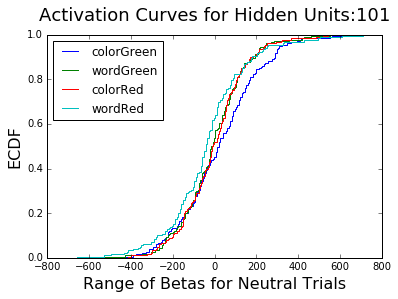

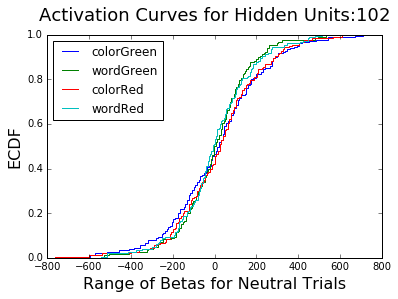

In [233]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

bias_curves = {}
i = 0
for subj in subjNums:
    bias_curves[subj] = {}
    color_green = np.where(zcontrast_color > 0)[0]
    color_red = np.where(zcontrast_color < 0)[0]
    word_green = np.where(zcontrast_word > 0)[0]
    word_red = np.where(zcontrast_word < 0)[0]
    neutral_ind = np.where(behavdata[subj]['condition']=='neutral')[0]

    bias_curves[subj]['colorGreen'] = np.mean(allbetas[subj][color_green,:][:,neutral_ind],axis=0)
    bias_curves[subj]['colorRed'] = np.mean(allbetas[subj][color_red,:][:,neutral_ind],axis=0)
    bias_curves[subj]['wordGreen'] = np.mean(allbetas[subj][word_green,:][:,neutral_ind],axis=0)
    bias_curves[subj]['wordRed'] = np.mean(allbetas[subj][word_red,:][:,neutral_ind],axis=0)

    plt.figure()
    plt.title('Activation Curves for Hidden Units:' + subj, fontsize=18, y=1.04)
    plt.ylabel('ECDF', fontsize=16)
    plt.xlabel('Range of Betas for Neutral Trials', fontsize=16)
    for key in bias_curves[subj].keys():
        sample = bias_curves[subj][key]
        ecdf = sm.distributions.ECDF(sample)
        x = np.linspace(min(sample), max(sample),num=sample.shape[0])
        y = ecdf(x)
#         bias = np.where(y==0.5)[0]
#         bias = x[bias]
        plt.step(x, y, label=key)
#         bias = x[sample.shape[0]/2]*-1 #(bias is negative of midway point)
    plt.legend(loc=2)
    plt.savefig(subj+'_ActivationCurve_HiddenLayers.pdf')

    

    i += 1

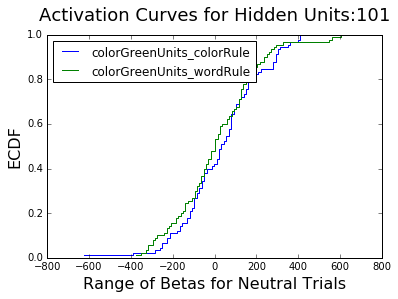

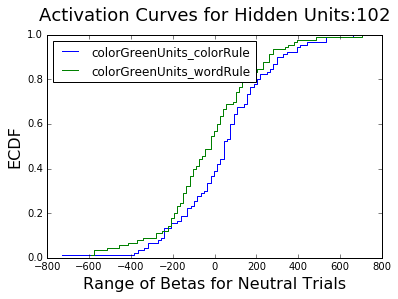

In [240]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

bias_curves = {}
i = 0
for subj in subjNums:
    bias_curves[subj] = {}
    color_green = np.where(zcontrast_color > 0)[0]
    color_red = np.where(zcontrast_color < 0)[0]
    word_green = np.where(zcontrast_word > 0)[0]
    word_red = np.where(zcontrast_word < 0)[0]
    neutral_ind = np.where(behavdata[subj]['condition']=='neutral')[0]
    color_i = np.where(behavdata[subj]['taskRule']=='color')[0]
    word_i = np.where(behavdata[subj]['taskRule']=='word')[0]
    neutral_color = np.intersect1d(neutral_ind,color_i)
    neutral_word = np.intersect1d(neutral_ind,word_i)

    bias_curves[subj]['colorGreenUnits_colorRule'] = np.mean(allbetas[subj][color_green,:][:,neutral_color],axis=0)
    bias_curves[subj]['colorGreenUnits_wordRule'] = np.mean(allbetas[subj][color_green,:][:,neutral_word],axis=0)
#     bias_curves[subj]['wordGreen'] = np.mean(allbetas[subj][word_green,:][:,neutral_ind],axis=0)
#     bias_curves[subj]['wordRed'] = np.mean(allbetas[subj][word_red,:][:,neutral_ind],axis=0)

    plt.figure()
    plt.title('Activation Curves for Hidden Units:' + subj, fontsize=18, y=1.04)
    plt.ylabel('ECDF', fontsize=16)
    plt.xlabel('Range of Betas for Neutral Trials', fontsize=16)
    for key in bias_curves[subj].keys():
        sample = bias_curves[subj][key]
        ecdf = sm.distributions.ECDF(sample)
        x = np.linspace(min(sample), max(sample),num=sample.shape[0])
        y = ecdf(x)
#         bias = np.where(y==0.5)[0]
#         bias = x[bias]
        plt.step(x, y, label=key)
#         bias = x[sample.shape[0]/2]*-1 #(bias is negative of midway point)
    plt.legend(loc=2)
    plt.savefig(subj+'_colorGreenUnitsECDFs_HiddenLayers.pdf')

    

    i += 1

___

##### Run 2 classifications

Function for cross-validation

In [109]:
def runCV(svmmat, labels, cvs=10, leaveout=5, replacement=False):
    """
    Runs a cross validation given an svm matrix, labels, number of cross validations, and 
    number of leave outs for test predictions
    
    Assumes cross validation without replacement (for each train v. test prediction)
    """
    # Get number of classes
    classes = np.unique(labels)
    
    # Run cross-validation using Linear SVMs
    leaveout_total = leaveout*len(classes)

    # Spatially demean (across features, to ensure that mean activity does not factor into classification)
    spatialmean = np.mean(svmmat,axis=1)
    spatialmean.shape = (len(spatialmean),1)
    svmmat = svmmat - spatialmean
    
    # Start cross-validation
    nsamples = svmmat.shape[0]
    acc = []
    for cv in range(cvs):
        test_ind = []
        for stim in classes:
            stimlabs = np.where(labels==stim)[0]
            test_ind.extend(np.random.choice(stimlabs,leaveout,replace=replacement))
            
        test_ind = np.asarray(test_ind)
        train_ind = np.delete(np.arange(nsamples),test_ind)

        trainset = svmmat[train_ind,:]
        testset = svmmat[test_ind,:]
        # normalize train and test set according to train set mean & std
        mean = np.mean(trainset,axis=0)
        std = np.std(trainset,axis=0)
        trainset = np.divide((trainset - mean),std)
        testset = np.divide((testset - mean),std)

        # Construct classifier and fit
        svc = SVC(kernel='linear')
        svc.fit(trainset,labels[train_ind])
        # Get acc
        acc.append(svc.score(testset,labels[test_ind]))

    # Get average accuracy
#     accmat[subj][roi_ind,0] = np.mean(acc)
    avg_acc = np.mean(acc)

    
    # Perform within-subject binomial test
    ntotal = leaveout_total*cvs
    nsuccess = avg_acc*ntotal
    chance = 1.0/len(classes)
    p = stats.binom_test(nsuccess,ntotal,p=chance)

    # Make sure it's a one-sided binomial test
    if avg_acc > chance:
        p = p/2.0
    else:
        p = 1.0 - p/2.0
    
    return avg_acc, p


#### Run actual code/cross-validations

In [13]:
accmat = {}
pmat = {}
qmat = {}
accmat_thresh = {}
nparcels = 360

for subj in subjNums:
    print 'Running classifications for subject', subj
    accmat[subj] = np.zeros((glasser.shape[0],2)) # 2 for accuracies and thresholded accuracies    
    pmat[subj] = np.zeros((nparcels,))
    
    for roi in range(nparcels):
        if nparcels%100==0:
            print 'Running classifications on ROI,', roi + 1
        roi_ind = np.where(glasser==roi+1)[0]
        
        ####
        ## Color V Word Rule classification        
        # Set up SVM Matrix
        mat_tmp = [] # For a 2-way classification
        labels_tmp = [] 
        for rule in range(nrules):
            mat_tmp.append(beta_dict[subj][roi_ind,:,rule].T)
            labels_tmp.append(np.ones((nsamples_perrule,1))*rule)
        svmmat_color = np.vstack(mat_tmp)
        labels_color = np.squeeze(np.vstack(labels_tmp))
        
        # Run cross-validation using Linear SVMs
        crossvalidations = 30 # 30-fold cross validation; 60 samples, 58 train; 2 test
        leaveout = 2 # leave out 2 samples of each stim

        acc, p = runCV(svmmat_color, labels_color, cvs=crossvalidations, leaveout=leaveout, replacement=False)
        accmat[subj][roi_ind,0] = acc
        pmat[subj][roi] = p
#         h0, qs = mc.fdrcorrection0(pmat[subj][:,0])
        
   

Running classifications for subject 101
Running classifications for subject 102


#### Run FDR correction for each test

In [14]:
accmat['101'].shape

(59412, 2)

In [16]:
qmat = {}
mvpa_mask = {}

for subj in subjNums:
    mvpa_mask[subj] = np.zeros(accmat[subj].shape)
    
    h0,qs = mc.fdrcorrection0(pmat[subj])

    # Iterate through each ROI and make sure it is significant
    for roi in range(nparcels):
        roi_ind = np.where(glasser==roi+1)[0]
        if qs[roi] < 0.05:
            mvpa_mask[subj][roi_ind,0] = 1.0
            accmat[subj][roi_ind,1] = accmat[subj][roi_ind,0]
#     tmp = np.max(accmat[subj][:,0])
#     roi_ind = accmat[subj][:,0] == tmp
#     for roi in rois: 
#         roi_ind = np.where(glasser==roi+1)[0]
#     mvpa_mask[subj][roi_ind,0] = 1.0
#     mvpa_mask[subj][:,0] = 1.0
#     accmat[subj][roi_ind,1] = accmat[subj][roi_ind,0]
            


### 2.2 Save MVPA maps to CSV and dscalar files

In [17]:
basedir = '/projects3/StroopActFlow/data/results/glm_ruleStimBetaSeries/taskRule_localizer/'
for subj in subjNums:
    
    filename_mvpa = basedir + subj + '_taskEncoding_MVPA_WordVColor_v2'
        
    np.savetxt(filename_mvpa + '.csv', accmat[subj], delimiter=',')
    convertCSVToCIFTI64k(filename_mvpa+'.csv', filename_mvpa+'.dscalar.nii')


## 3.0 Run GLM analysis on MVPA masks for Word V Color Rule separately

### 3.1 Perform univariate t-test on color stims

In [22]:
ttest_loc = {}

for subj in subjNums:
    # 1st column is for t-vals; 2nd for p; 3rd for FDR-corrected t-values
    # Vertex X stats matrix
    ttest_loc[subj] = np.zeros((mvpa_mask[subj].shape[0],2)) 

    # significant vertices in MVPA mask
    rule_ind = np.where(mvpa_mask[subj][:,0])[0]
    rule_ind = np.arange(mvpa_mask[subj].shape[0])
    
    # Perform color t-test first
    for v in rule_ind:
        t, p = stats.ttest_rel(beta_dict[subj][v,:,0],
                               beta_dict[subj][v,:,1])
        ttest_loc[subj][v,0], ttest_loc[subj][v,1] = t, p
    # Perform FDR-correction
#     h0, q = mc.fdrcorrection0(ttest_loc[subj]['color'][color_ind,1])
    h0 = ttest_loc[subj][rule_ind,1] < 0.05
    ttest_loc[subj][rule_ind,1] = np.multiply(h0,ttest_loc[subj][rule_ind,0])
        
        
    
        
        

### 3.2 Save statistical maps to CSV and dscalar files

In [23]:
for subj in subjNums:
    basedir = '/projects3/StroopActFlow/data/results/glm_ruleStimBetaSeries/taskRule_localizer/'
    filerule = basedir+subj+'_MVPAconstrained_ttestContrast_rules_v2'
    
    np.savetxt(filerule+'.csv', ttest_loc[subj], delimiter=',')
    
    convertCSVToCIFTI64k(filerule+'.csv', filerule+'.dscalar.nii')
